In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
!pip install seaborn

In [4]:
df = pd.read_csv("loan_data_processed.csv")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nDataset info:")
print(df.info())

print(f"\nTarget variable distribution:")
print(df['loan_status'].value_counts())
print(f"Default rate: {df['loan_status'].mean():.2%}")

Dataset shape: (31686, 22)
Columns: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_Y']

First 5 rows:
   person_age  person_income  person_emp_length  loan_amnt  loan_status  \
0          22          59000              123.0      35000            1   
1          21           9600                5.0       1000            0   
2          25           9600                1.0       5500            1   
3          23          65500                4.0      35000            1   
4          24          54400                8.0      35000            1   

   loan_percent_incom

In [5]:
# ELL 3: Feature Engineering on Preprocessed Data
# =============================================================================

def create_additional_features(df):
    """Create meaningful features from preprocessed data"""
    df_features = df.copy()
    
    # 1. Debt-to-income ratio (if not already loan_percent_income)
    df_features['debt_to_income_ratio'] = df_features['loan_amnt'] / df_features['person_income']
    
    # 2. Employment stability indicator
    df_features['employment_stable'] = np.where(df_features['person_emp_length'] >= 5, 1, 0)
    
    # 3. High loan amount flag (above 75th percentile)
    loan_threshold = df_features['loan_amnt'].quantile(0.75)
    df_features['high_loan_flag'] = np.where(df_features['loan_amnt'] > loan_threshold, 1, 0)
    
    # 4. Credit history maturity
    df_features['mature_credit_history'] = np.where(df_features['cb_person_cred_hist_length'] >= 10, 1, 0)
    
    # 5. Age groups (create binary indicators)
    df_features['young_borrower'] = np.where(df_features['person_age'] <= 30, 1, 0)
    df_features['senior_borrower'] = np.where(df_features['person_age'] >= 50, 1, 0)
    
    # 6. Income level indicators
    income_median = df_features['person_income'].median()
    df_features['high_income'] = np.where(df_features['person_income'] > income_median, 1, 0)
    
    print("✅ Additional features created:")
    new_features = [
        'debt_to_income_ratio', 'employment_stable', 'high_loan_flag', 
        'mature_credit_history', 'young_borrower', 'senior_borrower', 'high_income'
    ]
    for feature in new_features:
        print(f"   - {feature}")
    
    return df_features

# Apply feature engineering
df_enhanced = create_additional_features(df)
print(f"\nEnhanced dataset shape: {df_enhanced.shape}")

✅ Additional features created:
   - debt_to_income_ratio
   - employment_stable
   - high_loan_flag
   - mature_credit_history
   - young_borrower
   - senior_borrower
   - high_income

Enhanced dataset shape: (31686, 29)


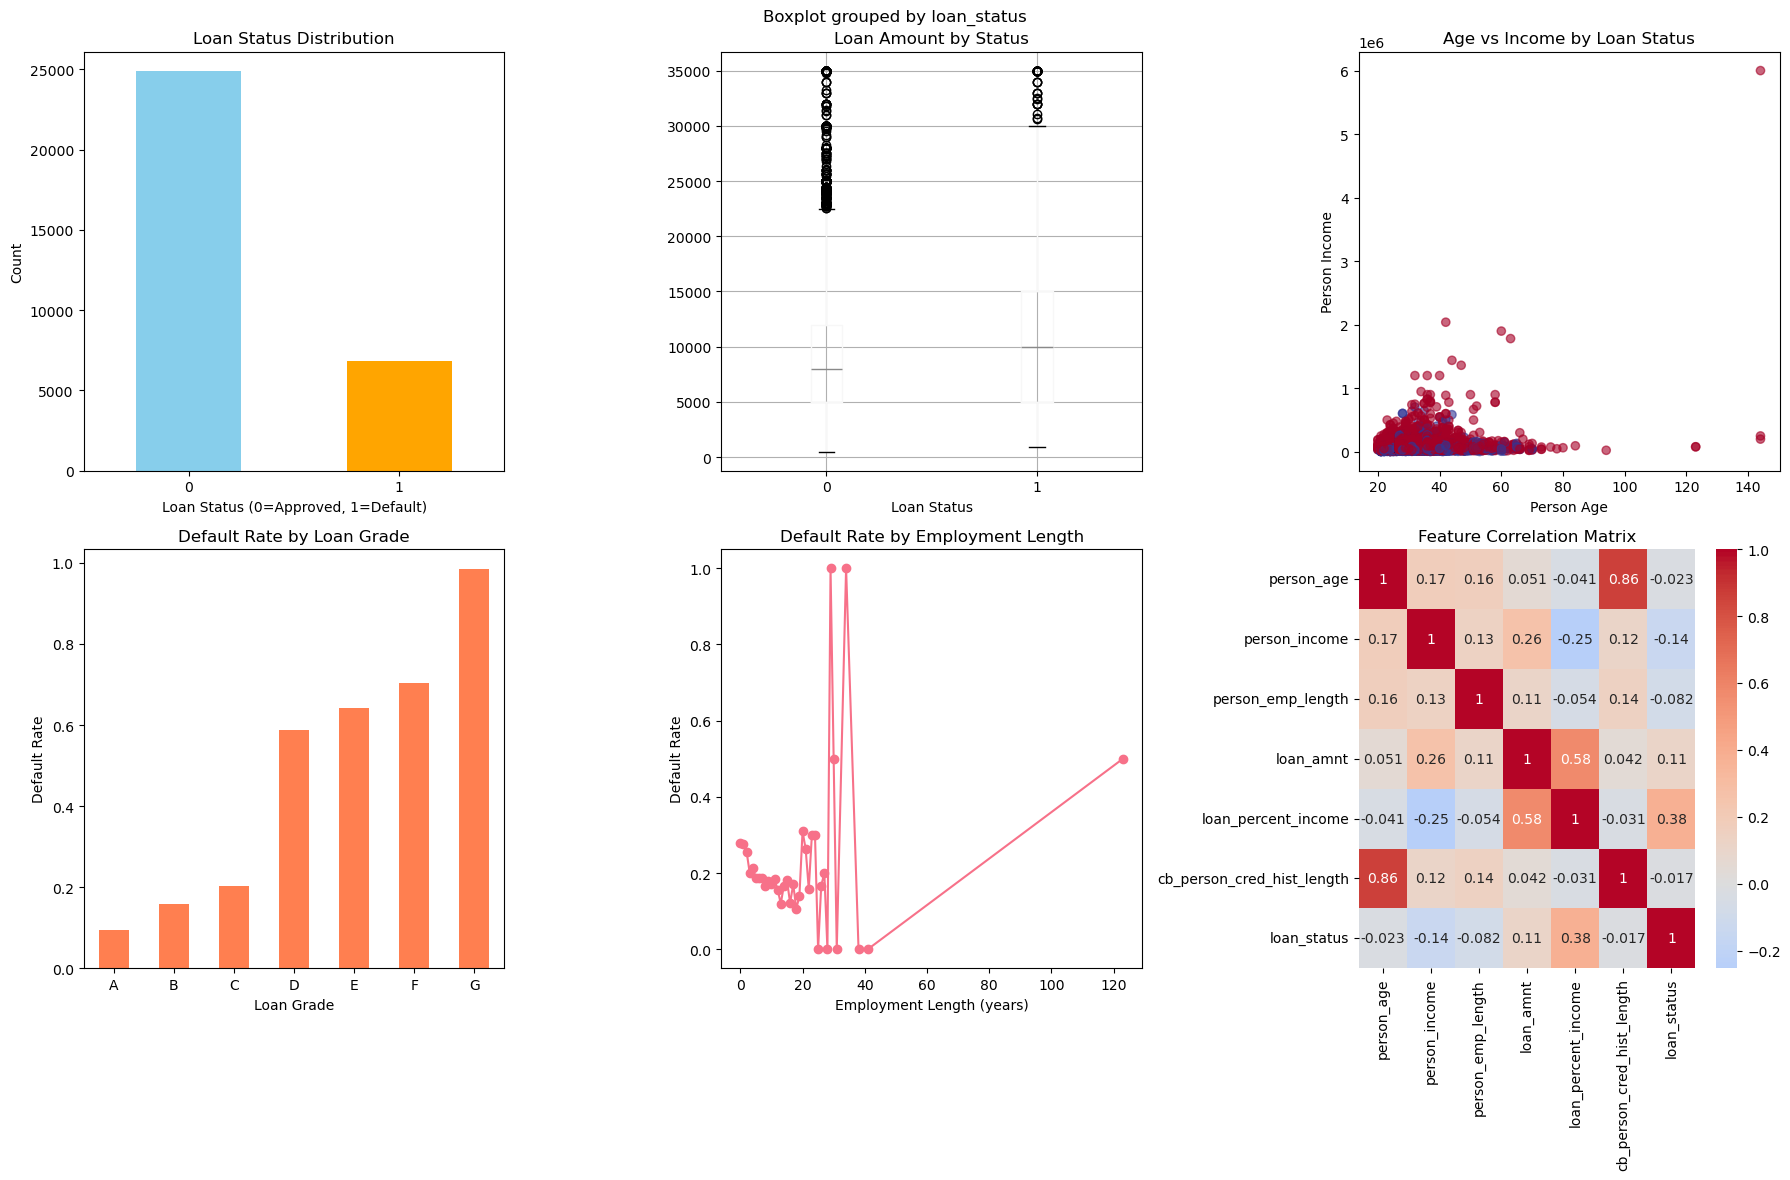

In [6]:
# CELL 4: Data Exploration and Visualization
# =============================================================================

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive exploratory analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Target distribution
df['loan_status'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'orange'])
axes[0,0].set_title('Loan Status Distribution')
axes[0,0].set_xlabel('Loan Status (0=Approved, 1=Default)')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Loan amount distribution by status
df.boxplot(column='loan_amnt', by='loan_status', ax=axes[0,1])
axes[0,1].set_title('Loan Amount by Status')
axes[0,1].set_xlabel('Loan Status')

# 3. Income vs Age colored by loan status
scatter = axes[0,2].scatter(df['person_age'], df['person_income'], 
                           c=df['loan_status'], alpha=0.6, cmap='RdYlBu')
axes[0,2].set_xlabel('Person Age')
axes[0,2].set_ylabel('Person Income')
axes[0,2].set_title('Age vs Income by Loan Status')

# 4. Loan grade distribution
grade_cols = [col for col in df.columns if col.startswith('loan_grade_')]
grade_data = []
for idx, row in df.iterrows():
    grade = 'A'  # Default grade
    for col in grade_cols:
        if row[col] == 1:
            grade = col.split('_')[-1]
            break
    grade_data.append(grade)

df['loan_grade_viz'] = grade_data
grade_default_rate = df.groupby('loan_grade_viz')['loan_status'].mean()
grade_default_rate.plot(kind='bar', ax=axes[1,0], color='coral')
axes[1,0].set_title('Default Rate by Loan Grade')
axes[1,0].set_xlabel('Loan Grade')
axes[1,0].set_ylabel('Default Rate')
axes[1,0].tick_params(axis='x', rotation=0)

# 5. Employment length vs default
emp_default = df.groupby('person_emp_length')['loan_status'].mean()
axes[1,1].plot(emp_default.index, emp_default.values, marker='o')
axes[1,1].set_xlabel('Employment Length (years)')
axes[1,1].set_ylabel('Default Rate')
axes[1,1].set_title('Default Rate by Employment Length')

# 6. Correlation heatmap of numeric features
numeric_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
               'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

In [7]:
# CELL 5: Model Training and Comparison
# =============================================================================

class CreditRiskModel:
    def __init__(self):
        self.models = {}
        self.best_model = None
        self.calibrated_model = None
        self.feature_names = None
    
    def prepare_data(self, df):
        """Prepare features and target"""
        # Separate features and target
        X = df.drop('loan_status', axis=1)
        y = df['loan_status']
        
        # Remove visualization column if present
        if 'loan_grade_viz' in X.columns:
            X = X.drop('loan_grade_viz', axis=1)
        
        self.feature_names = X.columns.tolist()
        return X, y
    
    def train_models(self, X_train, y_train):
        """Train multiple models and compare performance"""
        
        # Define models to test
        models_config = {
            'Random Forest': RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                class_weight='balanced',
                random_state=42
            ),
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                min_samples_split=5,
                random_state=42
            ),
            'Logistic Regression': LogisticRegression(
                class_weight='balanced',
                random_state=42,
                max_iter=1000,
                C=1.0
            )
        }
        
        # Train and evaluate each model
        model_scores = {}
        print("=== Model Training and Cross-Validation ===")
        
        for name, model in models_config.items():
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
            model_scores[name] = cv_scores.mean()
            
            # Train on full training set
            model.fit(X_train, y_train)
            self.models[name] = model
            
            print(f"{name}:")
            print(f"  CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Select best model
        best_model_name = max(model_scores, key=model_scores.get)
        self.best_model = self.models[best_model_name]
        
        # Calibrate probabilities for better risk assessment
        self.calibrated_model = CalibratedClassifierCV(self.best_model, method='sigmoid', cv=3)
        self.calibrated_model.fit(X_train, y_train)
        
        print(f"\n🏆 Best model: {best_model_name} (ROC-AUC: {model_scores[best_model_name]:.4f})")
        return model_scores

# Initialize and prepare data
risk_model = CreditRiskModel()
X, y = risk_model.prepare_data(df_enhanced)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Feature count: {len(X.columns)}")

# Train models
model_scores = risk_model.train_models(X_train, y_train)


Training set shape: (25348, 28)
Test set shape: (6338, 28)
Feature count: 28
=== Model Training and Cross-Validation ===
Random Forest:
  CV ROC-AUC: 0.9213 (+/- 0.0100)
Gradient Boosting:
  CV ROC-AUC: 0.9478 (+/- 0.0075)
Logistic Regression:
  CV ROC-AUC: 0.8496 (+/- 0.0154)

🏆 Best model: Gradient Boosting (ROC-AUC: 0.9478)


In [8]:
# CELL 5: Model Training and Comparison
# =============================================================================

class CreditRiskModel:
    def __init__(self):
        self.models = {}
        self.best_model = None
        self.calibrated_model = None
        self.feature_names = None
    
    def prepare_data(self, df):
        """Prepare features and target"""
        # Separate features and target
        X = df.drop('loan_status', axis=1)
        y = df['loan_status']
        
        # Remove visualization column if present
        if 'loan_grade_viz' in X.columns:
            X = X.drop('loan_grade_viz', axis=1)
        
        self.feature_names = X.columns.tolist()
        return X, y
    
    def train_models(self, X_train, y_train):
        """Train multiple models and compare performance"""
        
        # Define models to test
        models_config = {
            'Random Forest': RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                class_weight='balanced',
                random_state=42
            ),
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                min_samples_split=5,
                random_state=42
            ),
            'Logistic Regression': LogisticRegression(
                class_weight='balanced',
                random_state=42,
                max_iter=1000,
                C=1.0
            )
        }
        
        # Train and evaluate each model
        model_scores = {}
        print("=== Model Training and Cross-Validation ===")
        
        for name, model in models_config.items():
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
            model_scores[name] = cv_scores.mean()
            
            # Train on full training set
            model.fit(X_train, y_train)
            self.models[name] = model
            
            print(f"{name}:")
            print(f"  CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Select best model
        best_model_name = max(model_scores, key=model_scores.get)
        self.best_model = self.models[best_model_name]
        
        # Calibrate probabilities for better risk assessment
        self.calibrated_model = CalibratedClassifierCV(self.best_model, method='sigmoid', cv=3)
        self.calibrated_model.fit(X_train, y_train)
        
        print(f"\n🏆 Best model: {best_model_name} (ROC-AUC: {model_scores[best_model_name]:.4f})")
        return model_scores

# Initialize and prepare data
risk_model = CreditRiskModel()
X, y = risk_model.prepare_data(df_enhanced)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Feature count: {len(X.columns)}")

# Train models
model_scores = risk_model.train_models(X_train, y_train)


Training set shape: (25348, 28)
Test set shape: (6338, 28)
Feature count: 28
=== Model Training and Cross-Validation ===
Random Forest:
  CV ROC-AUC: 0.9213 (+/- 0.0100)
Gradient Boosting:
  CV ROC-AUC: 0.9478 (+/- 0.0075)
Logistic Regression:
  CV ROC-AUC: 0.8496 (+/- 0.0154)

🏆 Best model: Gradient Boosting (ROC-AUC: 0.9478)


=== MODEL PERFORMANCE EVALUATION ===
ROC-AUC Score: 0.9415

Confusion Matrix:
[[4936   37]
 [ 390  975]]

Additional Metrics:
Precision: 0.9634
Recall (Sensitivity): 0.7143
Specificity: 0.9926

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4973
           1       0.96      0.71      0.82      1365

    accuracy                           0.93      6338
   macro avg       0.95      0.85      0.89      6338
weighted avg       0.93      0.93      0.93      6338



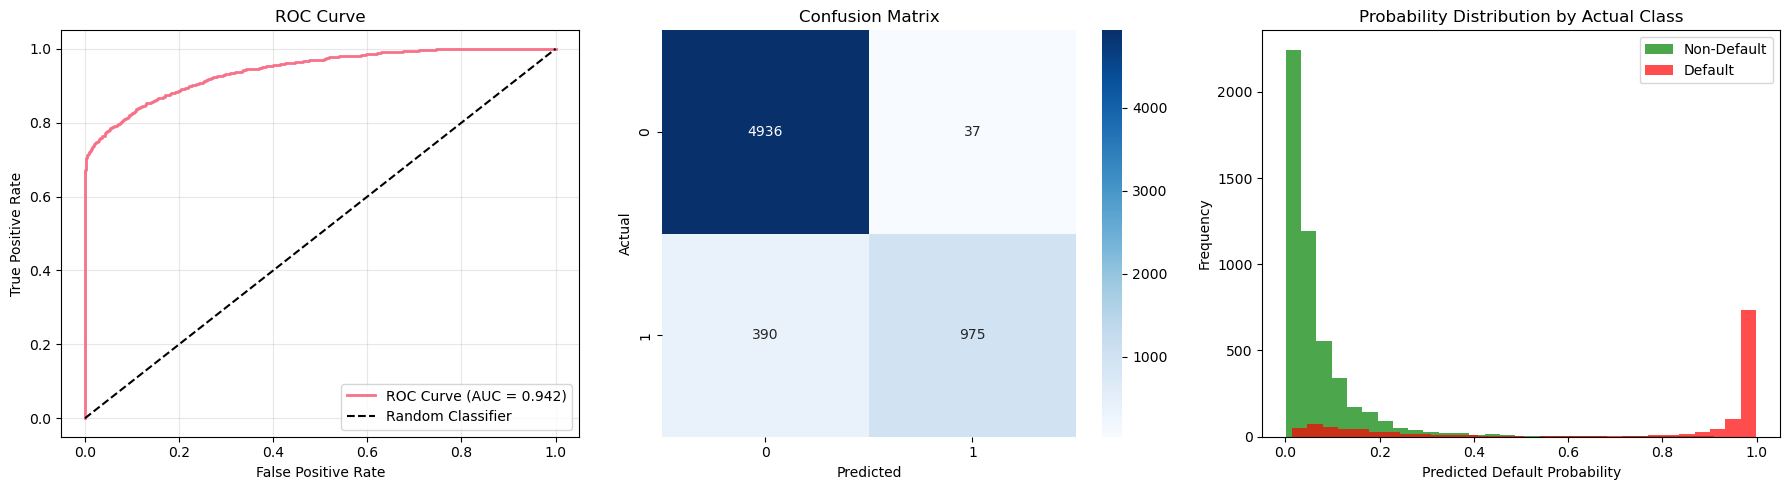

In [10]:
# CELL 6: Model Evaluation and Validation
# =============================================================================

def evaluate_model_performance(model, X_test, y_test):
    """Comprehensive model evaluation"""
    
    # Get predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print("=== MODEL PERFORMANCE EVALUATION ===")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nAdditional Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', linewidth=2)
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    # Probability Distribution
    axes[2].hist(y_proba[y_test == 0], bins=30, alpha=0.7, label='Non-Default', color='green')
    axes[2].hist(y_proba[y_test == 1], bins=30, alpha=0.7, label='Default', color='red')
    axes[2].set_xlabel('Predicted Default Probability')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Probability Distribution by Actual Class')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return y_pred, y_proba, roc_auc

# Evaluate the best model
y_pred, y_proba, roc_auc = evaluate_model_performance(risk_model.calibrated_model, X_test, y_test)


=== TOP 15 MOST IMPORTANT FEATURES ===
                        feature  importance
21         debt_to_income_ratio    0.296675
8    person_home_ownership_RENT    0.155222
16                 loan_grade_D    0.139419
1                 person_income    0.113641
17                 loan_grade_E    0.053175
2             person_emp_length    0.039567
11          loan_intent_MEDICAL    0.023829
7     person_home_ownership_OWN    0.020668
18                 loan_grade_F    0.018523
9         loan_intent_EDUCATION    0.017477
12         loan_intent_PERSONAL    0.017353
10  loan_intent_HOMEIMPROVEMENT    0.016741
0                    person_age    0.015804
13          loan_intent_VENTURE    0.015082
4           loan_percent_income    0.014722


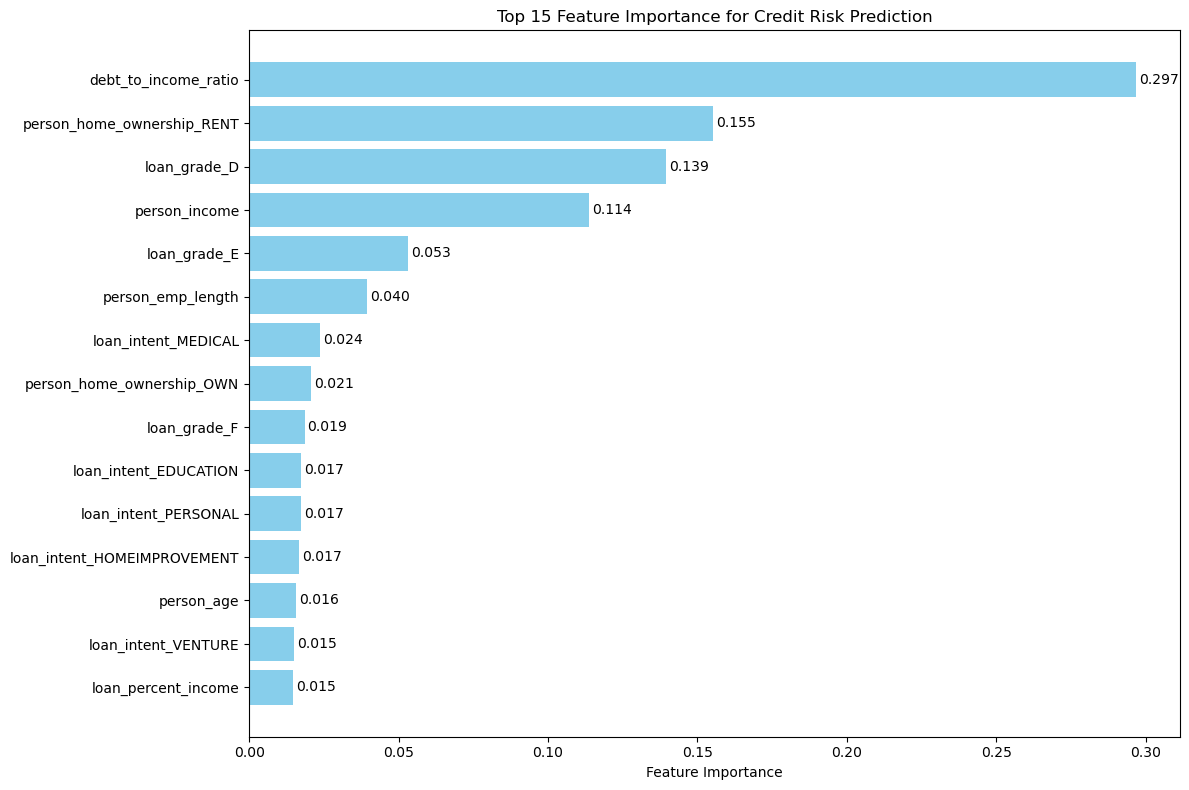

In [11]:
# CELL 7: Feature Importance Analysis
# =============================================================================

def analyze_feature_importance(model, feature_names):
    """Analyze and visualize feature importance"""

    # If model is calibrated, grab the underlying estimator
    if isinstance(model, CalibratedClassifierCV):
        base_model = model.calibrated_classifiers_[0].estimator
    else:
        base_model = model

    # Extract feature importances if available
    if hasattr(base_model, 'feature_importances_'):
        importances = base_model.feature_importances_
    else:
        print("Feature importance not available for this model type")
        return None
    
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("=== TOP 15 MOST IMPORTANT FEATURES ===")
    print(feature_importance_df.head(15))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importance for Credit Risk Prediction')
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, v in enumerate(top_features['importance']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df


# Analyze feature importance
feature_importance = analyze_feature_importance(risk_model.calibrated_model, risk_model.feature_names)

=== INTEREST RATE ASSIGNMENT COMPARISON ===
      linear  risk_adjusted  exponential  tiered
Mean  0.0931         0.0864       0.1019  0.0936
Std   0.0368         0.0370       0.0350  0.0407
Min   0.0701         0.0700       0.0702  0.0700
Max   0.1800         0.1799       0.1745  0.1800


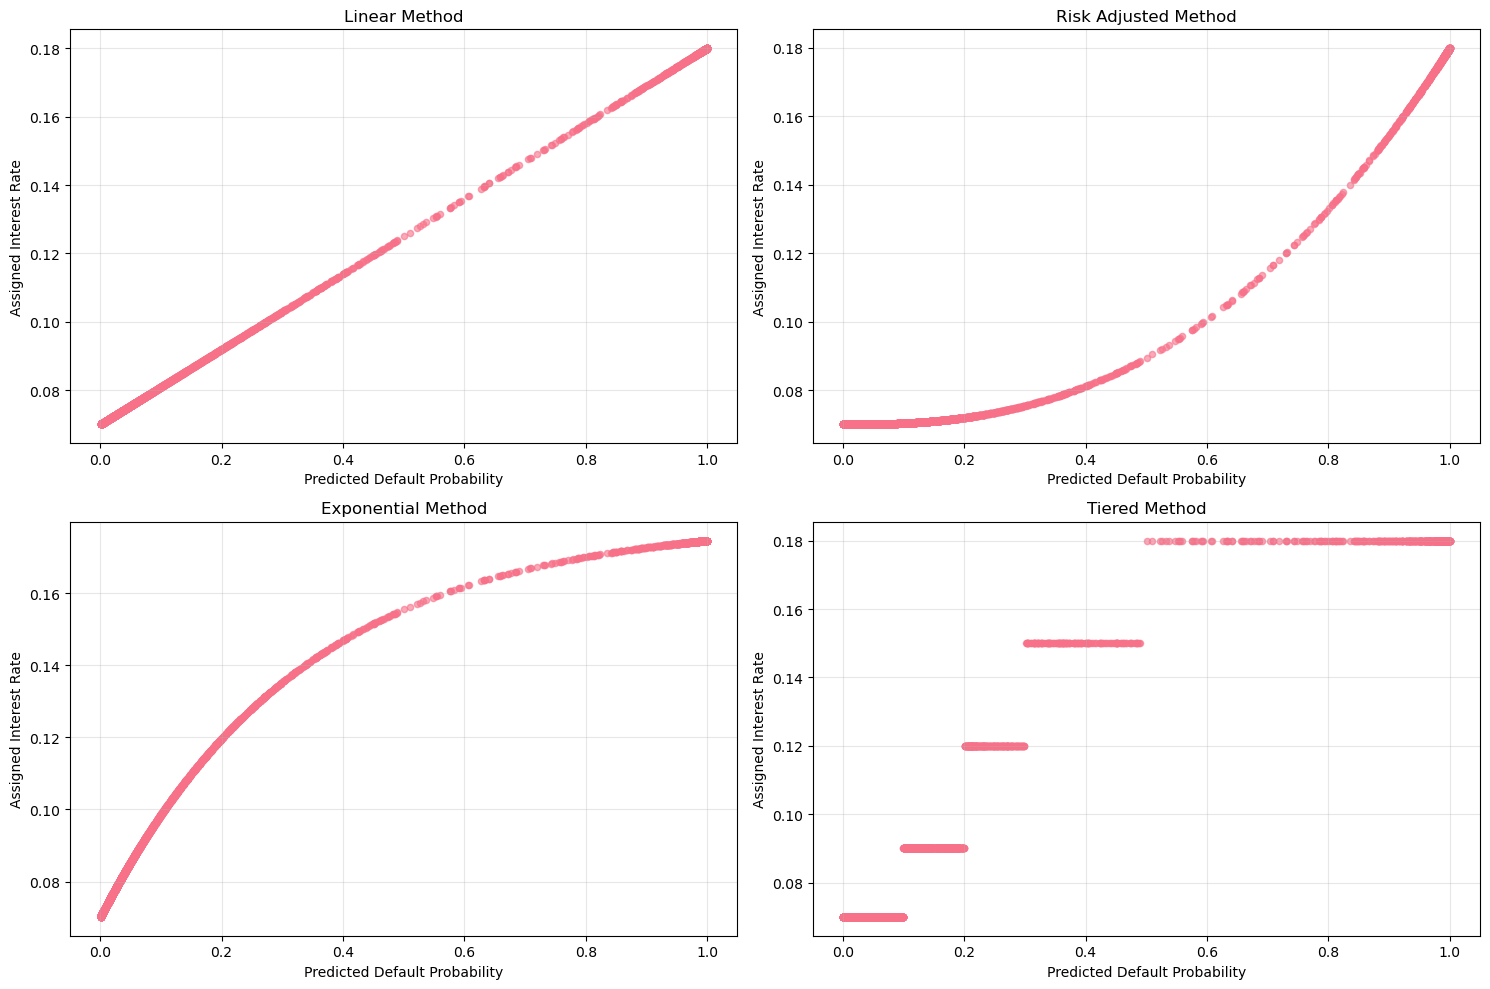

In [12]:
# CELL 8: Interest Rate Assignment Strategies
# =============================================================================

def assign_interest_rates(probabilities, method='risk_adjusted', r_min=0.07, r_max=0.18):
    """
    Assign interest rates based on default probability
    
    Args:
        probabilities: Array of default probabilities
        method: 'linear', 'risk_adjusted', 'tiered', or 'exponential'
        r_min: Minimum interest rate (7%)
        r_max: Maximum interest rate (18%)
    """
    
    if method == 'linear':
        # Simple linear mapping
        rates = r_min + (r_max - r_min) * probabilities
        
    elif method == 'risk_adjusted':
        # Exponential mapping that heavily penalizes high risk
        k = 2.5  # Exponent for risk adjustment
        rates = r_min + (r_max - r_min) * (probabilities ** k)
        
    elif method == 'exponential':
        # Exponential growth mapping
        alpha = 3.0  # Steepness parameter
        rates = r_min + (r_max - r_min) * (1 - np.exp(-alpha * probabilities))
        
    elif method == 'tiered':
        # Business-friendly discrete tiers
        rates = np.select([
            probabilities <= 0.1,   # Very low risk
            probabilities <= 0.2,   # Low risk
            probabilities <= 0.3,   # Medium risk
            probabilities <= 0.5,   # High risk
            probabilities > 0.5     # Very high risk
        ], [0.07, 0.09, 0.12, 0.15, 0.18], default=0.18)
    
    else:
        raise ValueError("Method must be one of: 'linear', 'risk_adjusted', 'exponential', 'tiered'")
    
    return np.clip(rates, r_min, r_max)

# Create results dataframe
results = X_test.copy()
results['actual_status'] = y_test
results['predicted_default_prob'] = y_proba

# Test different interest rate assignment methods
methods = ['linear', 'risk_adjusted', 'exponential', 'tiered']
for method in methods:
    results[f'interest_rate_{method}'] = assign_interest_rates(y_proba, method=method)

# Display comparison
print("=== INTEREST RATE ASSIGNMENT COMPARISON ===")
comparison_stats = pd.DataFrame({
    method: [
        results[f'interest_rate_{method}'].mean(),
        results[f'interest_rate_{method}'].std(),
        results[f'interest_rate_{method}'].min(),
        results[f'interest_rate_{method}'].max()
    ] for method in methods
}, index=['Mean', 'Std', 'Min', 'Max'])

print(comparison_stats.round(4))

# Visualize different rate assignment strategies
plt.figure(figsize=(15, 10))

for i, method in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    plt.scatter(results['predicted_default_prob'], results[f'interest_rate_{method}'], 
               alpha=0.6, s=20)
    plt.xlabel('Predicted Default Probability')
    plt.ylabel('Assigned Interest Rate')
    plt.title(f'{method.replace("_", " ").title()} Method')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== INTEREST RATE: EXPONENTIAL vs REGRESSION (SUMMARY) ===
                             Method  Mean Rate  Std Dev   Min     Max
0              Exponential (PD^2.5)     0.0864   0.0370  0.07  0.1799
1  Regression (break-even + buffer)     0.1248   0.0521  0.07  0.1800


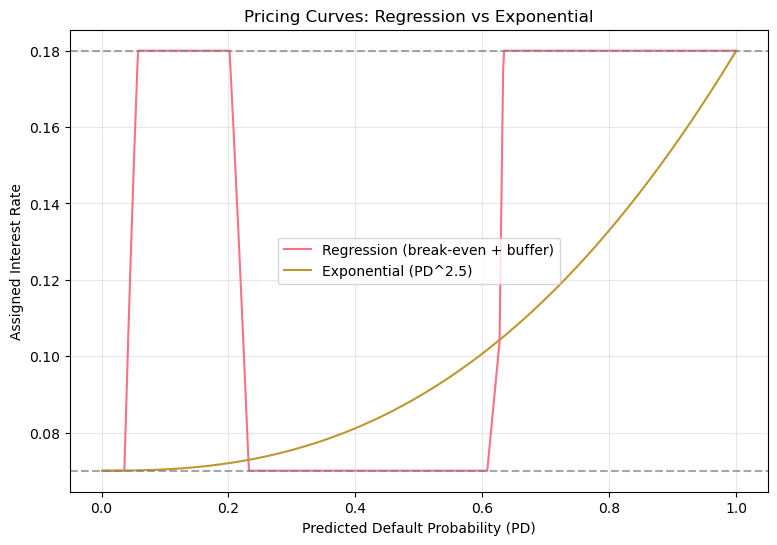

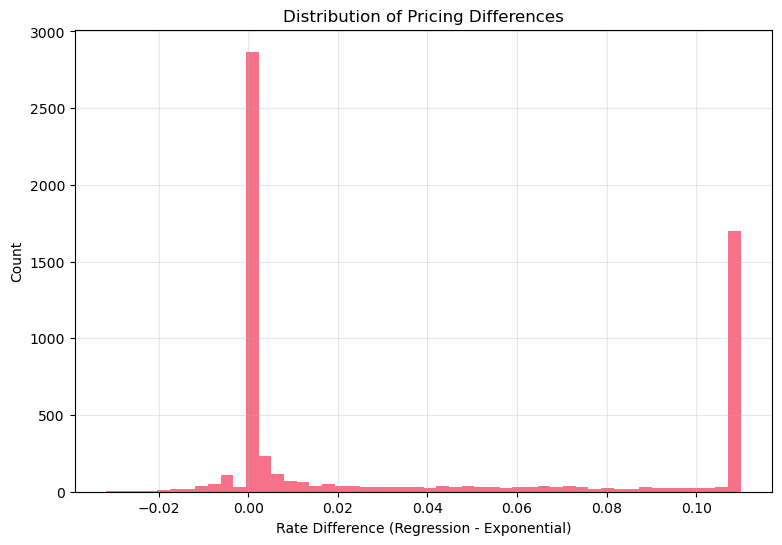


[Info] Skipped portfolio optimization with regression-based rates because:
name 'optimize_portfolio' is not defined


In [13]:
# CELL X: Regression-based Pricing (Break-even + Smoothed Regression)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# --- Parameters ---
LGD = 0.60
R_MIN, R_MAX = 0.07, 0.18   # 7% to 18% caps
MARGIN = 0.015              # 150 bps buffer
POLY_DEGREE = 3             # degree of polynomial smoothing

# --- Step 1: Break-even (fair) rate ---
pd_vals = results['predicted_default_prob'].astype(float).values
pd_safe = np.clip(pd_vals, 1e-6, 0.95)                # avoid blow-ups
fair_rate_raw = (pd_safe * LGD) / (1 - pd_safe)       # unbounded

# --- Step 2: Polynomial regression smoothing ---
X = pd_safe.reshape(-1, 1)
poly = PolynomialFeatures(POLY_DEGREE, include_bias=False)
X_poly = poly.fit_transform(X)

reg = LinearRegression().fit(X_poly, fair_rate_raw)
fair_rate_smoothed = reg.predict(X_poly)

# --- Step 3: Add buffer + apply caps ---
rate_regression = np.clip(fair_rate_smoothed + MARGIN, R_MIN, R_MAX)

# --- Step 4: Save to results ---
results['rate_fair_raw_unclipped'] = fair_rate_raw
results['rate_regression_smoothed'] = fair_rate_smoothed
results['interest_rate_regression'] = rate_regression

# --- Step 5: Summary table ---
summary = pd.DataFrame({
    "Method": ["Exponential (PD^2.5)", "Regression (break-even + buffer)"],
    "Mean Rate": [
        results['interest_rate_risk_adjusted'].mean() if 'interest_rate_risk_adjusted' in results else np.nan,
        results['interest_rate_regression'].mean()
    ],
    "Std Dev": [
        results['interest_rate_risk_adjusted'].std() if 'interest_rate_risk_adjusted' in results else np.nan,
        results['interest_rate_regression'].std()
    ],
    "Min": [
        results['interest_rate_risk_adjusted'].min() if 'interest_rate_risk_adjusted' in results else np.nan,
        results['interest_rate_regression'].min()
    ],
    "Max": [
        results['interest_rate_risk_adjusted'].max() if 'interest_rate_risk_adjusted' in results else np.nan,
        results['interest_rate_regression'].max()
    ]
})
print("=== INTEREST RATE: EXPONENTIAL vs REGRESSION (SUMMARY) ===")
print(summary.round(4))

# --- Step 6A: Pricing curves (PD vs rate) ---
plt.figure(figsize=(9,6))
order = np.argsort(pd_vals)
plt.plot(pd_vals[order], results['interest_rate_regression'].values[order],
         label="Regression (break-even + buffer)")
if 'interest_rate_risk_adjusted' in results:
    plt.plot(pd_vals[order], results['interest_rate_risk_adjusted'].values[order],
             label="Exponential (PD^2.5)")
plt.axhline(R_MIN, linestyle="--", color="gray", alpha=0.7)
plt.axhline(R_MAX, linestyle="--", color="gray", alpha=0.7)
plt.xlabel("Predicted Default Probability (PD)")
plt.ylabel("Assigned Interest Rate")
plt.title("Pricing Curves: Regression vs Exponential")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Step 6B: Rate difference distribution ---
if 'interest_rate_risk_adjusted' in results:
    diff = results['interest_rate_regression'] - results['interest_rate_risk_adjusted']
    plt.figure(figsize=(9,6))
    plt.hist(diff.dropna(), bins=50)
    plt.xlabel("Rate Difference (Regression - Exponential)")
    plt.ylabel("Count")
    plt.title("Distribution of Pricing Differences")
    plt.grid(alpha=0.3)
    plt.show()

# --- Step 7: Portfolio optimization (optional) ---
try:
    portfolio_metrics_reg, top_applicants_reg, _ = optimize_portfolio(
        results.copy(), acceptance_rate=0.30, rate_method="regression", lgd=LGD
    )
    print("\n=== PORTFOLIO (Regression-based Pricing @ 30% acceptance) ===")
    print(f"Total Expected Profit: ${portfolio_metrics_reg['total_expected_profit']:,.0f}")
    print(f"Profit Margin: {portfolio_metrics_reg['profit_margin']:.2%}")
    print(f"Average Interest Rate: {portfolio_metrics_reg['average_interest_rate']:.2%}")
    print(f"Average Default Risk: {portfolio_metrics_reg['average_default_probability']:.2%}")
except Exception as e:
    print("\n[Info] Skipped portfolio optimization with regression-based rates because:")
    print(e)

In [14]:
# CELL 9: Portfolio Optimization and Profit Maximization
# =============================================================================

def calculate_expected_profit(loan_amount, interest_rate, default_prob, lgd=0.6):
    """Calculate expected profit for a loan"""
    expected_revenue = (1 - default_prob) * loan_amount * interest_rate
    expected_loss = default_prob * loan_amount * lgd
    return expected_revenue - expected_loss

def optimize_portfolio(results_df, acceptance_rate=0.3, lgd=0.6, rate_method='risk_adjusted'):
    """
    Optimize portfolio selection for maximum profitability
    
    Args:
        results_df: DataFrame with loan applications and risk scores
        acceptance_rate: Fraction of applicants to accept (0.3 = 30%)
        lgd: Loss Given Default (0.6 = 60%)
        rate_method: Interest rate assignment method to use
    """
    
    # Calculate expected profit for each applicant
    interest_rate_col = f'interest_rate_{rate_method}'
    results_df['expected_profit'] = calculate_expected_profit(
        results_df['loan_amnt'],
        results_df[interest_rate_col],
        results_df['predicted_default_prob'],
        lgd
    )
    
    # Sort by expected profit (descending)
    sorted_results = results_df.sort_values('expected_profit', ascending=False)
    
    # Select top applicants
    n_accept = int(acceptance_rate * len(sorted_results))
    top_applicants = sorted_results.head(n_accept)
    
    # Calculate portfolio metrics
    portfolio_metrics = {
        'total_applicants': len(results_df),
        'accepted_applicants': n_accept,
        'acceptance_rate': acceptance_rate,
        'total_loan_amount': top_applicants['loan_amnt'].sum(),
        'total_expected_profit': top_applicants['expected_profit'].sum(),
        'average_default_probability': top_applicants['predicted_default_prob'].mean(),
        'average_interest_rate': top_applicants[interest_rate_col].mean(),
        'expected_losses': (top_applicants['predicted_default_prob'] * 
                           top_applicants['loan_amnt'] * lgd).sum(),
        'profit_margin': 0,  # Will calculate below
        'sharpe_ratio': 0    # Risk-adjusted return metric
    }
    
    # Calculate profit margin and Sharpe ratio
    if portfolio_metrics['total_loan_amount'] > 0:
        portfolio_metrics['profit_margin'] = (
            portfolio_metrics['total_expected_profit'] / portfolio_metrics['total_loan_amount']
        )
    
    # Simple Sharpe ratio approximation (profit/risk)
    portfolio_risk = portfolio_metrics['average_default_probability']
    portfolio_metrics['sharpe_ratio'] = (
        portfolio_metrics['profit_margin'] / portfolio_risk if portfolio_risk > 0 else 0
    )
    
    return portfolio_metrics, top_applicants, sorted_results

# Optimize portfolio using risk-adjusted pricing
portfolio_metrics, top_applicants, sorted_results = optimize_portfolio(
    results, acceptance_rate=0.3, rate_method='risk_adjusted'
)

# Display results
print("=== PORTFOLIO OPTIMIZATION RESULTS ===")
print(f"📊 Total Applicants: {portfolio_metrics['total_applicants']:,}")
print(f"✅ Accepted Applicants: {portfolio_metrics['accepted_applicants']:,}")
print(f"📈 Acceptance Rate: {portfolio_metrics['acceptance_rate']:.1%}")
print(f"💰 Total Loan Amount: ${portfolio_metrics['total_loan_amount']:,.2f}")
print(f"🎯 Maximum Expected Profit: ${portfolio_metrics['total_expected_profit']:,.2f}")
print(f"⚠️  Average Default Risk: {portfolio_metrics['average_default_probability']:.2%}")
print(f"💳 Average Interest Rate: {portfolio_metrics['average_interest_rate']:.2%}")
print(f"💸 Expected Losses: ${portfolio_metrics['expected_losses']:,.2f}")
print(f"📊 Profit Margin: {portfolio_metrics['profit_margin']:.2%}")
print(f"📈 Risk-Adjusted Return (Sharpe): {portfolio_metrics['sharpe_ratio']}")

=== PORTFOLIO OPTIMIZATION RESULTS ===
📊 Total Applicants: 6,338
✅ Accepted Applicants: 1,901
📈 Acceptance Rate: 30.0%
💰 Total Loan Amount: $26,017,300.00
🎯 Maximum Expected Profit: $1,405,899.58
⚠️  Average Default Risk: 2.16%
💳 Average Interest Rate: 7.00%
💸 Expected Losses: $372,359.83
📊 Profit Margin: 5.40%
📈 Risk-Adjusted Return (Sharpe): 2.5026870109823163


=== SENSITIVITY ANALYSIS ===
Acceptance Rate | Total Profit | Avg Risk | Profit/Loan | Sharpe Ratio
----------------------------------------------------------------------
        10.0% | $   690,240 |   1.77% |     5.69% |       3.21
        15.0% | $   916,862 |   1.84% |     5.63% |       3.06
        20.0% | $ 1,109,010 |   1.96% |     5.55% |       2.83
        25.0% | $ 1,269,803 |   2.05% |     5.48% |       2.67
        30.0% | $ 1,405,900 |   2.16% |     5.40% |       2.50
        35.0% | $ 1,522,594 |   2.27% |     5.33% |       2.35
        40.0% | $ 1,623,841 |   2.38% |     5.26% |       2.21
        45.0% | $ 1,709,463 |   2.51% |     5.19% |       2.07
        50.0% | $ 1,778,461 |   2.67% |     5.10% |       1.91

🎯 OPTIMAL ACCEPTANCE RATE: 50.0%
🏆 MAXIMUM EXPECTED PROFIT: $1,778,461.44


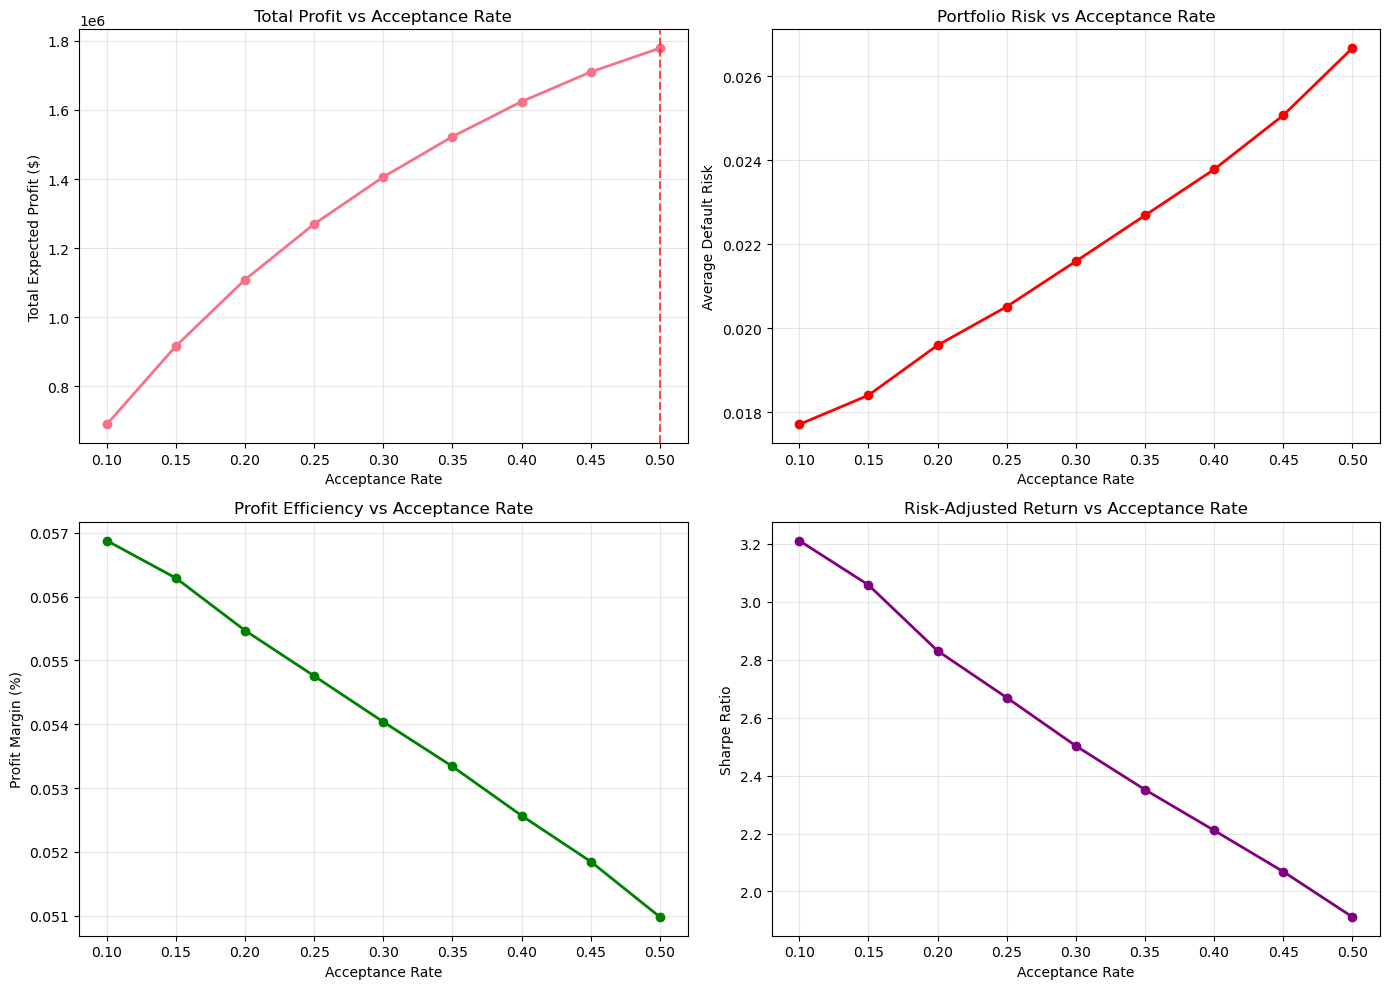

In [15]:
# CELL 10: Sensitivity Analysis
# =============================================================================

def sensitivity_analysis(results_df, lgd=0.6):
    """Analyze portfolio performance across different acceptance rates"""
    
    acceptance_rates = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    analysis_results = []
    
    print("=== SENSITIVITY ANALYSIS ===")
    print("Acceptance Rate | Total Profit | Avg Risk | Profit/Loan | Sharpe Ratio")
    print("-" * 70)
    
    for rate in acceptance_rates:
        metrics, _, _ = optimize_portfolio(results_df, acceptance_rate=rate, lgd=lgd)
        
        analysis_results.append({
            'acceptance_rate': rate,
            'total_profit': metrics['total_expected_profit'],
            'avg_risk': metrics['average_default_probability'],
            'profit_per_loan': metrics['profit_margin'],
            'sharpe_ratio': metrics['sharpe_ratio'],
            'total_exposure': metrics['total_loan_amount']
        })
        
        print(f"{rate:13.1%} | ${metrics['total_expected_profit']:10,.0f} | "
              f"{metrics['average_default_probability']:7.2%} | "
              f"{metrics['profit_margin']:9.2%} | {metrics['sharpe_ratio']:10.2f}")
    
    # Convert to DataFrame for analysis
    sensitivity_df = pd.DataFrame(analysis_results)
    
    # Find optimal acceptance rate
    optimal_rate_idx = sensitivity_df['total_profit'].idxmax()
    optimal_rate = sensitivity_df.loc[optimal_rate_idx, 'acceptance_rate']
    optimal_profit = sensitivity_df.loc[optimal_rate_idx, 'total_profit']
    
    print(f"\n🎯 OPTIMAL ACCEPTANCE RATE: {optimal_rate:.1%}")
    print(f"🏆 MAXIMUM EXPECTED PROFIT: ${optimal_profit:,.2f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Total profit vs acceptance rate
    axes[0,0].plot(sensitivity_df['acceptance_rate'], sensitivity_df['total_profit'], 
                   marker='o', linewidth=2, markersize=6)
    axes[0,0].axvline(optimal_rate, color='red', linestyle='--', alpha=0.7)
    axes[0,0].set_xlabel('Acceptance Rate')
    axes[0,0].set_ylabel('Total Expected Profit ($)')
    axes[0,0].set_title('Total Profit vs Acceptance Rate')
    axes[0,0].grid(True, alpha=0.3)
    
    # Average risk vs acceptance rate
    axes[0,1].plot(sensitivity_df['acceptance_rate'], sensitivity_df['avg_risk'], 
                   marker='o', color='red', linewidth=2, markersize=6)
    axes[0,1].set_xlabel('Acceptance Rate')
    axes[0,1].set_ylabel('Average Default Risk')
    axes[0,1].set_title('Portfolio Risk vs Acceptance Rate')
    axes[0,1].grid(True, alpha=0.3)
    
    # Profit per loan vs acceptance rate
    axes[1,0].plot(sensitivity_df['acceptance_rate'], sensitivity_df['profit_per_loan'], 
                   marker='o', color='green', linewidth=2, markersize=6)
    axes[1,0].set_xlabel('Acceptance Rate')
    axes[1,0].set_ylabel('Profit Margin (%)')
    axes[1,0].set_title('Profit Efficiency vs Acceptance Rate')
    axes[1,0].grid(True, alpha=0.3)
    
    # Sharpe ratio (risk-adjusted return)
    axes[1,1].plot(sensitivity_df['acceptance_rate'], sensitivity_df['sharpe_ratio'], 
                   marker='o', color='purple', linewidth=2, markersize=6)
    axes[1,1].set_xlabel('Acceptance Rate')
    axes[1,1].set_ylabel('Sharpe Ratio')
    axes[1,1].set_title('Risk-Adjusted Return vs Acceptance Rate')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return sensitivity_df

# Run sensitivity analysis
sensitivity_results = sensitivity_analysis(results.copy())

=== RISK SEGMENT ANALYSIS ===
               predicted_default_prob       interest_rate_risk_adjusted  \
                                 mean count                        mean   
risk_segment                                                              
Very Low Risk                  0.0350  4178                      0.0701   
Low Risk                       0.1403   770                      0.0709   
Medium Risk                    0.2414   236                      0.0732   
High Risk                      0.3828   142                      0.0803   
Very High Risk                 0.9553  1012                      0.1695   

               expected_profit            loan_amnt             actual_status  
                           sum       mean       sum        mean          mean  
risk_segment                                                                   
Very Low Risk     1.886343e+06   451.4944  39623575   9483.8619        0.0383  
Low Risk         -1.471228e+05  -191.0685   63949

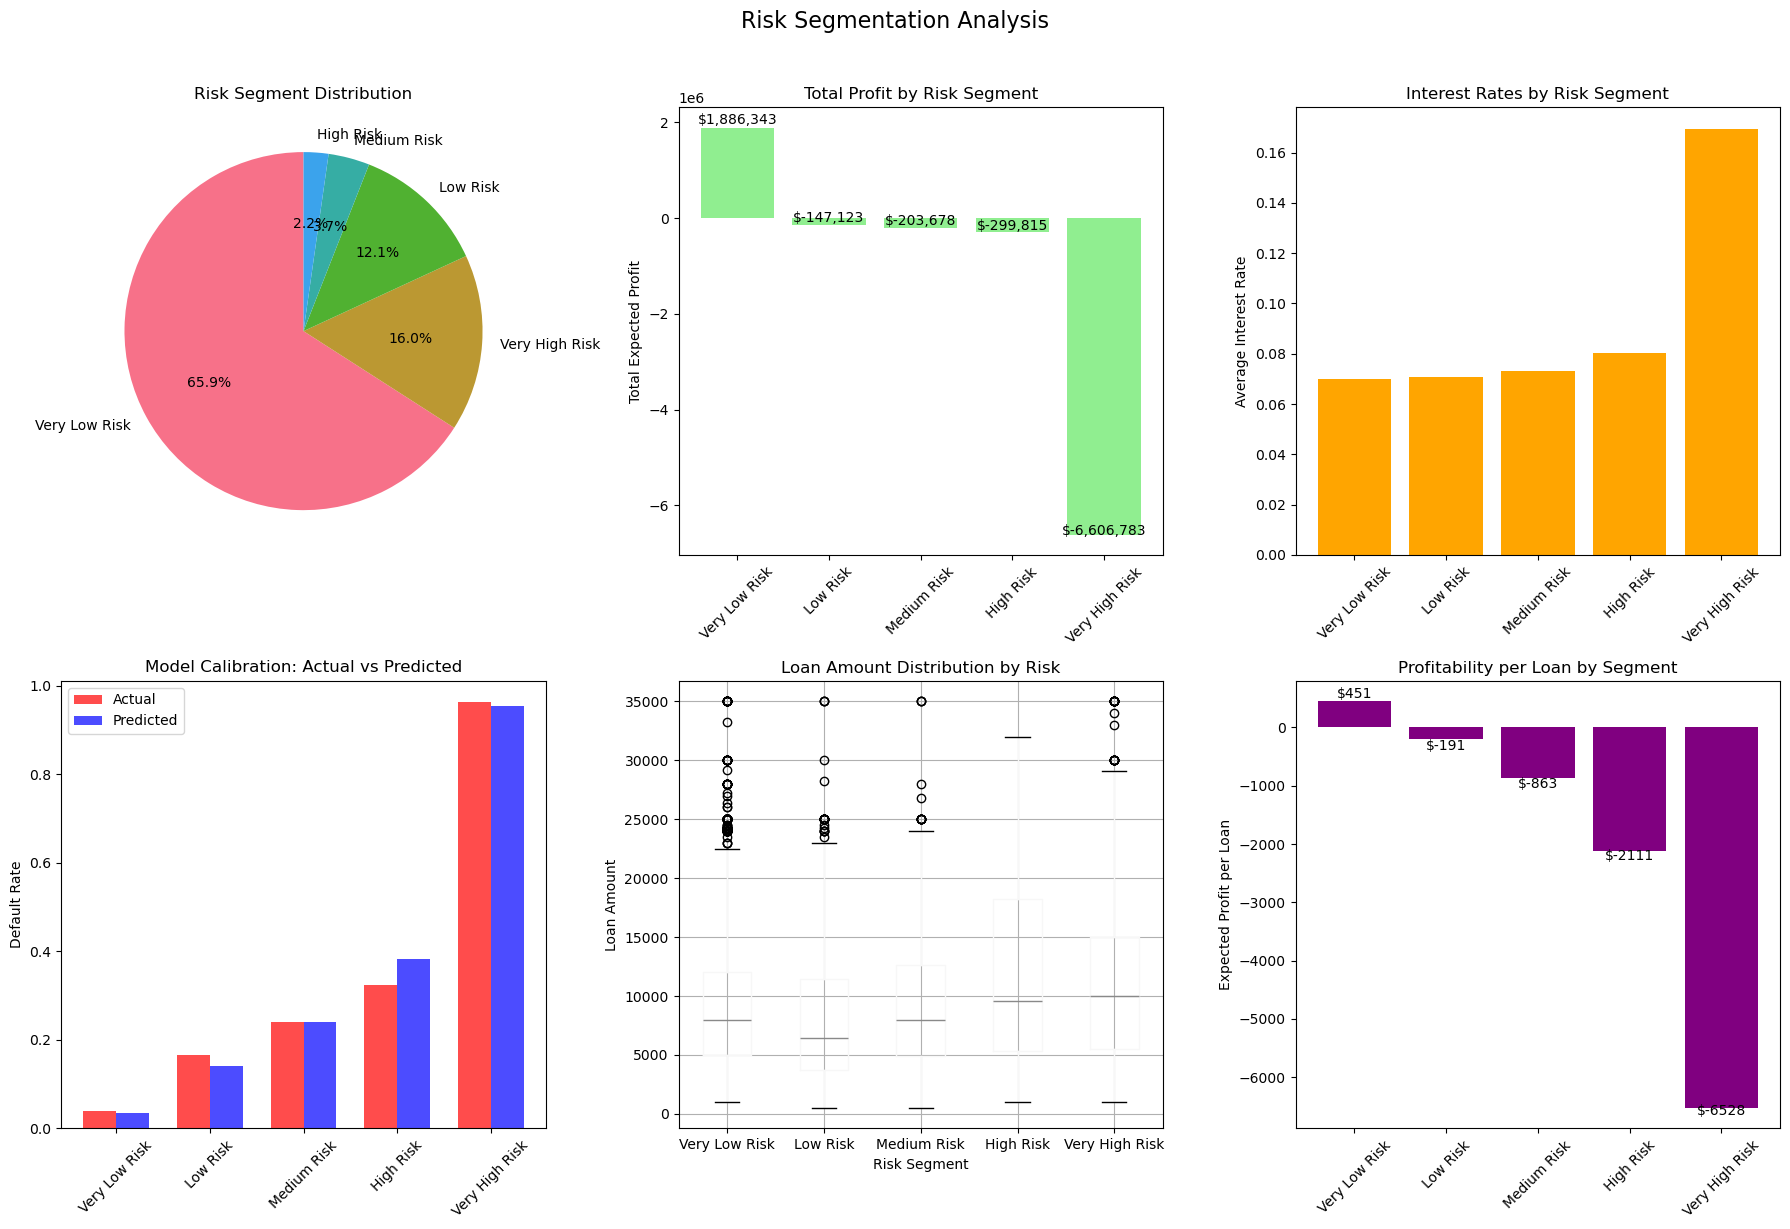

In [16]:
# CELL 11: Risk Segmentation and Business Insights
# =============================================================================

def risk_segmentation_analysis(results_df):
    """Comprehensive risk segmentation for business insights"""
    
    # Create risk segments based on default probability
    results_df['risk_segment'] = pd.cut(
        results_df['predicted_default_prob'],
        bins=[0, 0.1, 0.2, 0.3, 0.5, 1.0],
        labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'],
        include_lowest=True
    )
    
    # Segment analysis
    segment_stats = results_df.groupby('risk_segment').agg({
        'predicted_default_prob': ['mean', 'count'],
        'interest_rate_risk_adjusted': 'mean',
        'expected_profit': ['sum', 'mean'],
        'loan_amnt': ['sum', 'mean'],
        'actual_status': 'mean'  # Actual default rate
    }).round(4)
    
    print("=== RISK SEGMENT ANALYSIS ===")
    print(segment_stats)
    
    # Create business insights visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Segment distribution
    segment_counts = results_df['risk_segment'].value_counts()
    axes[0,0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('Risk Segment Distribution')
    
    # 2. Profit by segment
    segment_profit = results_df.groupby('risk_segment')['expected_profit'].sum()
    bars = axes[0,1].bar(range(len(segment_profit)), segment_profit.values, color='lightgreen')
    axes[0,1].set_xticks(range(len(segment_profit)))
    axes[0,1].set_xticklabels(segment_profit.index, rotation=45)
    axes[0,1].set_ylabel('Total Expected Profit')
    axes[0,1].set_title('Total Profit by Risk Segment')
    
    # Add value labels on bars
    for bar, value in zip(bars, segment_profit.values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01,
                      f'${value:,.0f}', ha='center', va='bottom')
    
    # 3. Interest rates by segment
    segment_rates = results_df.groupby('risk_segment')['interest_rate_risk_adjusted'].mean()
    axes[0,2].bar(range(len(segment_rates)), segment_rates.values, color='orange')
    axes[0,2].set_xticks(range(len(segment_rates)))
    axes[0,2].set_xticklabels(segment_rates.index, rotation=45)
    axes[0,2].set_ylabel('Average Interest Rate')
    axes[0,2].set_title('Interest Rates by Risk Segment')
    
    # 4. Actual vs Predicted default rates
    actual_rates = results_df.groupby('risk_segment')['actual_status'].mean()
    predicted_rates = results_df.groupby('risk_segment')['predicted_default_prob'].mean()
    
    x_pos = np.arange(len(actual_rates))
    width = 0.35
    
    axes[1,0].bar(x_pos - width/2, actual_rates.values, width, label='Actual', color='red', alpha=0.7)
    axes[1,0].bar(x_pos + width/2, predicted_rates.values, width, label='Predicted', color='blue', alpha=0.7)
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(actual_rates.index, rotation=45)
    axes[1,0].set_ylabel('Default Rate')
    axes[1,0].set_title('Model Calibration: Actual vs Predicted')
    axes[1,0].legend()
    
    # 5. Loan amount distribution by segment
    results_df.boxplot(column='loan_amnt', by='risk_segment', ax=axes[1,1])
    axes[1,1].set_xlabel('Risk Segment')
    axes[1,1].set_ylabel('Loan Amount')
    axes[1,1].set_title('Loan Amount Distribution by Risk')
    
    # 6. Expected profit per loan by segment
    profit_per_loan = results_df.groupby('risk_segment')['expected_profit'].mean()
    bars = axes[1,2].bar(range(len(profit_per_loan)), profit_per_loan.values, color='purple')
    axes[1,2].set_xticks(range(len(profit_per_loan)))
    axes[1,2].set_xticklabels(profit_per_loan.index, rotation=45)
    axes[1,2].set_ylabel('Expected Profit per Loan')
    axes[1,2].set_title('Profitability per Loan by Segment')
    
    # Add value labels
    for bar, value in zip(bars, profit_per_loan.values):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + abs(value)*0.01,
                      f'${value:.0f}', ha='center', va='bottom' if value >= 0 else 'top')
    
    plt.suptitle('Risk Segmentation Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return segment_stats

# Run risk segmentation analysis
segment_analysis = risk_segmentation_analysis(results.copy())

In [17]:
# CELL 12: Advanced Portfolio Analysis
# =============================================================================

def advanced_portfolio_metrics(top_applicants, all_results, lgd=0.6):
    """Calculate advanced portfolio risk and return metrics"""
    
    # Portfolio composition
    total_portfolio_value = top_applicants['loan_amnt'].sum()
    weighted_avg_rate = (top_applicants['loan_amnt'] * top_applicants['interest_rate_risk_adjusted']).sum() / total_portfolio_value
    weighted_avg_risk = (top_applicants['loan_amnt'] * top_applicants['predicted_default_prob']).sum() / total_portfolio_value
    
    # Expected annual revenue and losses
    expected_annual_revenue = total_portfolio_value * weighted_avg_rate
    expected_annual_losses = total_portfolio_value * weighted_avg_risk * lgd
    net_expected_return = expected_annual_revenue - expected_annual_losses
    
    # Portfolio diversification metrics
    loan_grade_diversity = len([col for col in top_applicants.columns if col.startswith('loan_grade_') and top_applicants[col].sum() > 0])
    intent_diversity = len([col for col in top_applicants.columns if col.startswith('loan_intent_') and top_applicants[col].sum() > 0])
    
    # Risk concentration
    top_10_loans = top_applicants.nlargest(10, 'loan_amnt')['loan_amnt'].sum()
    concentration_ratio = top_10_loans / total_portfolio_value
    
    # Value at Risk (VaR) approximation
    # 95% VaR: potential loss at 95% confidence level
    default_losses = top_applicants['predicted_default_prob'] * top_applicants['loan_amnt'] * lgd
    var_95 = np.percentile(default_losses, 95)
    
    advanced_metrics = {
        'portfolio_value': total_portfolio_value,
        'weighted_avg_interest_rate': weighted_avg_rate,
        'weighted_avg_default_risk': weighted_avg_risk,
        'expected_annual_revenue': expected_annual_revenue,
        'expected_annual_losses': expected_annual_losses,
        'net_expected_return': net_expected_return,
        'return_on_assets': net_expected_return / total_portfolio_value,
        'loan_grade_diversity': loan_grade_diversity,
        'loan_intent_diversity': intent_diversity,
        'concentration_ratio': concentration_ratio,
        'value_at_risk_95': var_95
    }
    
    return advanced_metrics

# Calculate advanced metrics
advanced_metrics = advanced_portfolio_metrics(top_applicants, results)

print("\n=== ADVANCED PORTFOLIO METRICS ===")
print(f"💼 Portfolio Value: ${advanced_metrics['portfolio_value']:,.2f}")
print(f"📊 Weighted Avg Interest Rate: {advanced_metrics['weighted_avg_interest_rate']:.2%}")
print(f"⚠️  Weighted Avg Default Risk: {advanced_metrics['weighted_avg_default_risk']:.2%}")
print(f"💰 Expected Annual Revenue: ${advanced_metrics['expected_annual_revenue']:,.2f}")
print(f"💸 Expected Annual Losses: ${advanced_metrics['expected_annual_losses']:,.2f}")
print(f"🎯 Net Expected Return: ${advanced_metrics['net_expected_return']:,.2f}")
print(f"📈 Return on Assets: {advanced_metrics['return_on_assets']:.2%}")
print(f"🏦 Loan Grade Diversity: {advanced_metrics['loan_grade_diversity']} grades")
print(f"🎯 Loan Intent Diversity: {advanced_metrics['loan_intent_diversity']} categories")
print(f"⚖️  Top 10 Loans Concentration: {advanced_metrics['concentration_ratio']:.1%}")
print(f"📉 Value at Risk (95%): ${advanced_metrics['value_at_risk_95']:,.2f}")


=== ADVANCED PORTFOLIO METRICS ===
💼 Portfolio Value: $26,017,300.00
📊 Weighted Avg Interest Rate: 7.00%
⚠️  Weighted Avg Default Risk: 2.39%
💰 Expected Annual Revenue: $1,821,725.70
💸 Expected Annual Losses: $372,359.83
🎯 Net Expected Return: $1,449,365.88
📈 Return on Assets: 5.57%
🏦 Loan Grade Diversity: 4 grades
🎯 Loan Intent Diversity: 5 categories
⚖️  Top 10 Loans Concentration: 1.3%
📉 Value at Risk (95%): $595.05


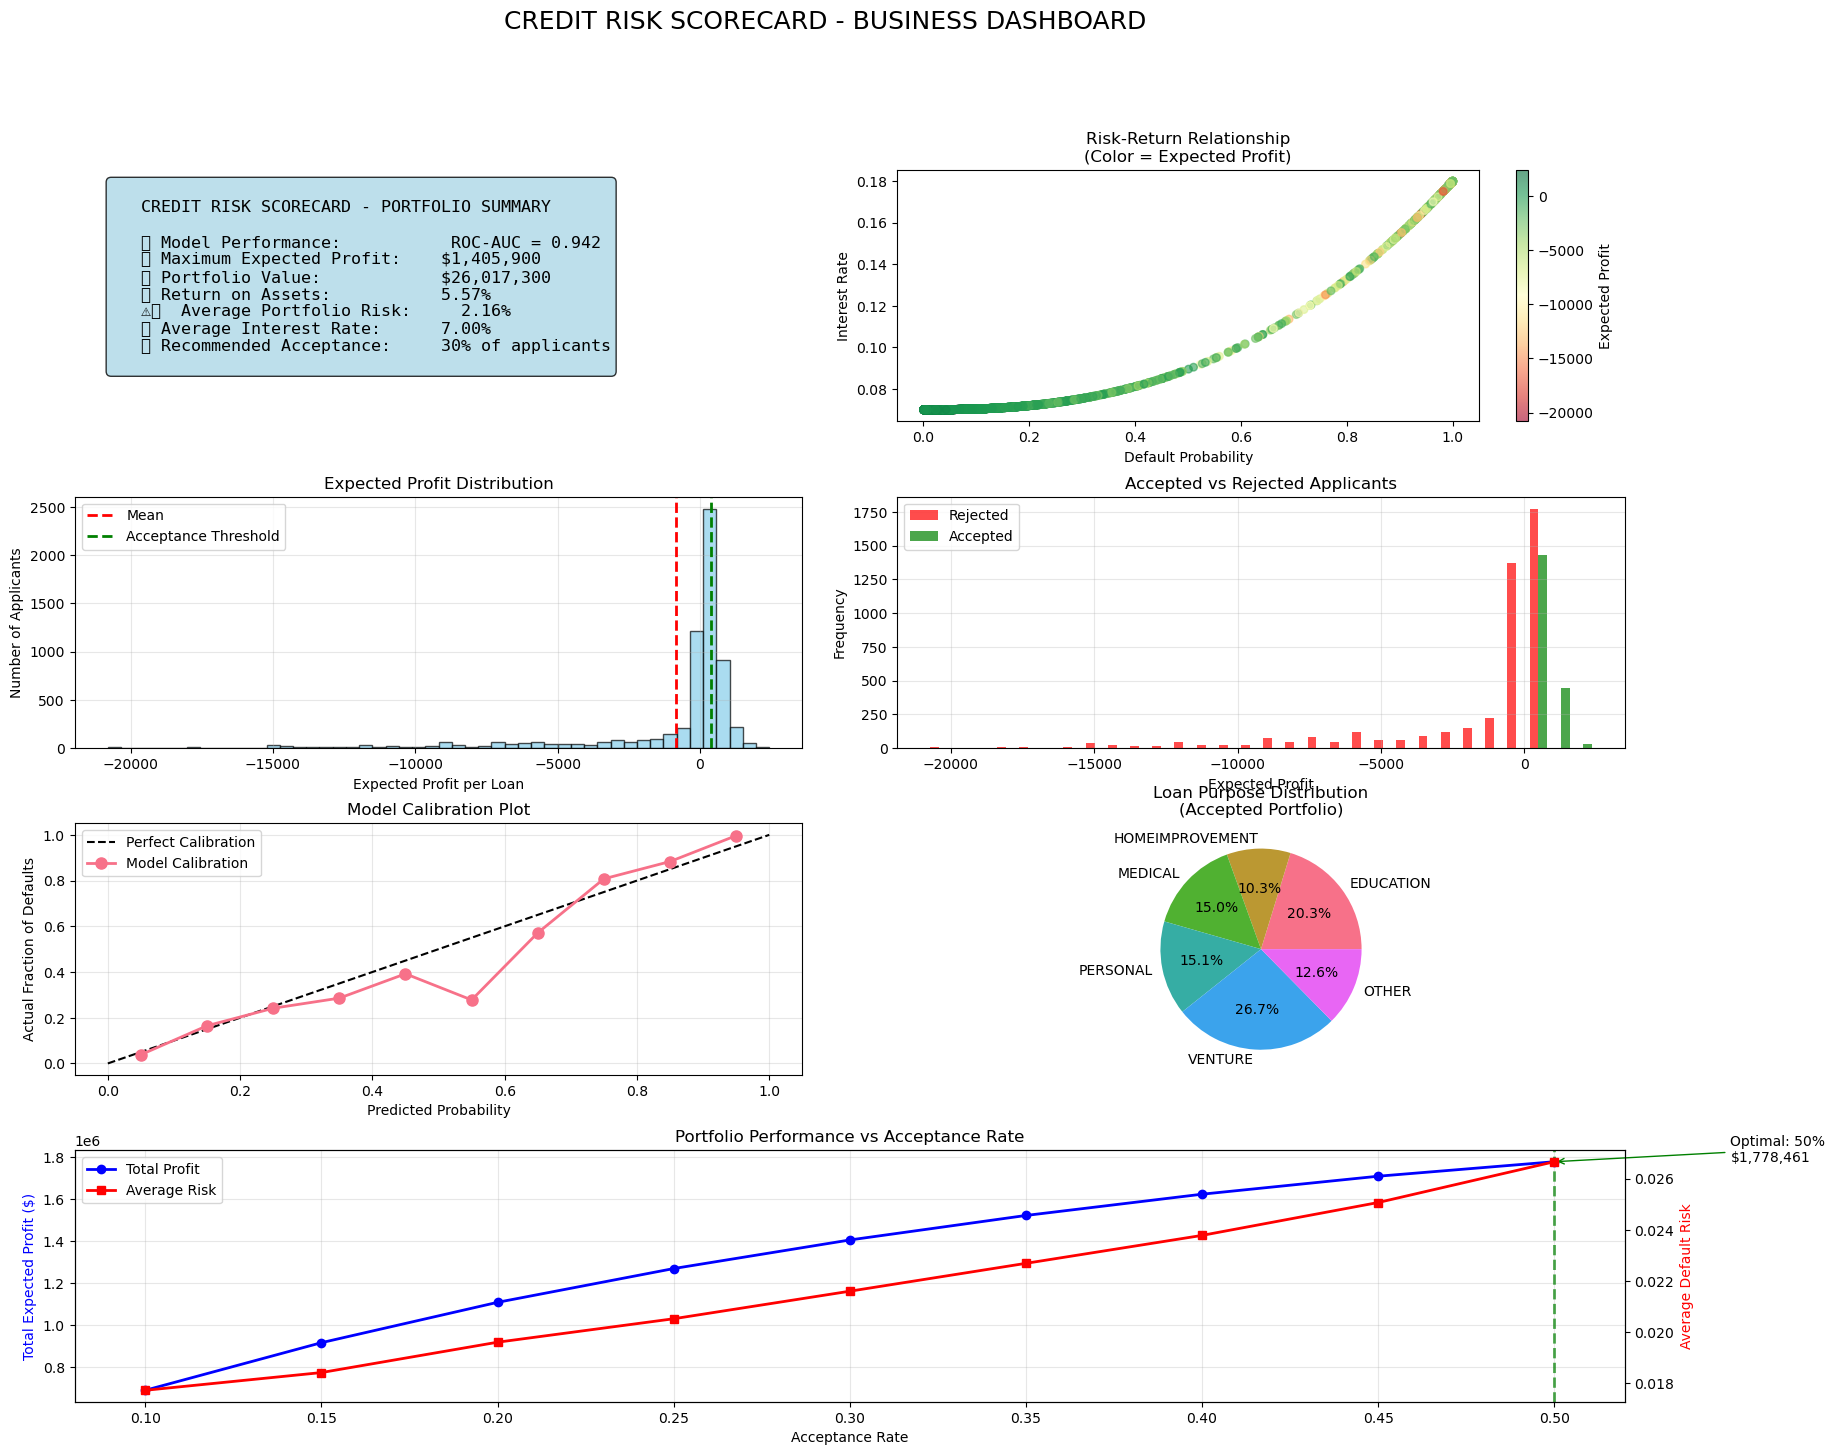

In [18]:
 #CELL 13: Business Dashboard Visualization
# =============================================================================

def create_business_dashboard(results_df, top_applicants, portfolio_metrics, advanced_metrics):
    """Create a comprehensive business dashboard"""
    
    # Set up the dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # Create a grid layout
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # 1. Portfolio Summary (top left, large)
    ax1 = fig.add_subplot(gs[0, :2])
    
    # Key metrics as text
    summary_text = f"""
    CREDIT RISK SCORECARD - PORTFOLIO SUMMARY
    
    📊 Model Performance:           ROC-AUC = {roc_auc:.3f}
    💰 Maximum Expected Profit:    ${portfolio_metrics['total_expected_profit']:,.0f}
    📈 Portfolio Value:            ${advanced_metrics['portfolio_value']:,.0f}
    📊 Return on Assets:           {advanced_metrics['return_on_assets']:.2%}
    ⚠️  Average Portfolio Risk:     {portfolio_metrics['average_default_probability']:.2%}
    💳 Average Interest Rate:      {portfolio_metrics['average_interest_rate']:.2%}
    ✅ Recommended Acceptance:     {portfolio_metrics['acceptance_rate']:.0%} of applicants
    """
    
    ax1.text(0.05, 0.95, summary_text, transform=ax1.transAxes, fontsize=12,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')
    
    # 2. Risk vs Return scatter (top right)
    ax2 = fig.add_subplot(gs[0, 2:])
    scatter = ax2.scatter(results_df['predicted_default_prob'], 
                         results_df['interest_rate_risk_adjusted'],
                         c=results_df['expected_profit'], 
                         cmap='RdYlGn', alpha=0.6, s=30)
    ax2.set_xlabel('Default Probability')
    ax2.set_ylabel('Interest Rate')
    ax2.set_title('Risk-Return Relationship\n(Color = Expected Profit)')
    plt.colorbar(scatter, ax=ax2, label='Expected Profit')
    
    # 3. Profit distribution (row 2, left)
    ax3 = fig.add_subplot(gs[1, :2])
    ax3.hist(results_df['expected_profit'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(results_df['expected_profit'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax3.axvline(top_applicants['expected_profit'].min(), color='green', linestyle='--', linewidth=2, label='Acceptance Threshold')
    ax3.set_xlabel('Expected Profit per Loan')
    ax3.set_ylabel('Number of Applicants')
    ax3.set_title('Expected Profit Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Acceptance visualization (row 2, right)
    ax4 = fig.add_subplot(gs[1, 2:])
    accepted_profit = top_applicants['expected_profit']
    rejected_profit = results_df[~results_df.index.isin(top_applicants.index)]['expected_profit']
    
    ax4.hist([rejected_profit, accepted_profit], bins=30, alpha=0.7, 
            label=['Rejected', 'Accepted'], color=['red', 'green'])
    ax4.set_xlabel('Expected Profit')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Accepted vs Rejected Applicants')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Risk calibration plot (row 3, left)
    ax5 = fig.add_subplot(gs[2, :2])
    
    # Create calibration bins
    n_bins = 10
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    bin_centers = []
    actual_fractions = []
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        mask = (results_df['predicted_default_prob'] > bin_lower) & (results_df['predicted_default_prob'] <= bin_upper)
        if mask.sum() > 0:
            bin_centers.append((bin_lower + bin_upper) / 2)
            actual_fractions.append(results_df[mask]['actual_status'].mean())
    
    ax5.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    ax5.plot(bin_centers, actual_fractions, marker='o', linewidth=2, markersize=8, label='Model Calibration')
    ax5.set_xlabel('Predicted Probability')
    ax5.set_ylabel('Actual Fraction of Defaults')
    ax5.set_title('Model Calibration Plot')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Loan portfolio composition (row 3, right)
    ax6 = fig.add_subplot(gs[2, 2:])
    
    # Loan intent distribution in accepted portfolio
    intent_cols = [col for col in top_applicants.columns if col.startswith('loan_intent_')]
    intent_distribution = {}
    for col in intent_cols:
        intent_name = col.replace('loan_intent_', '')
        intent_distribution[intent_name] = top_applicants[col].sum()
    
    # Add default category (when all intent columns are 0)
    intent_distribution['OTHER'] = len(top_applicants) - sum(intent_distribution.values())
    
    # Remove zero values
    intent_distribution = {k: v for k, v in intent_distribution.items() if v > 0}
    
    if intent_distribution:
        ax6.pie(intent_distribution.values(), labels=intent_distribution.keys(), autopct='%1.1f%%')
        ax6.set_title('Loan Purpose Distribution\n(Accepted Portfolio)')
    
    # 7. Sensitivity analysis summary (row 4, full width)
    ax7 = fig.add_subplot(gs[3, :])
    
    # Plot the sensitivity analysis results
    ax7_twin = ax7.twinx()
    
    line1 = ax7.plot(sensitivity_results['acceptance_rate'], sensitivity_results['total_profit'], 
                     'b-', marker='o', linewidth=2, markersize=6, label='Total Profit')
    line2 = ax7_twin.plot(sensitivity_results['acceptance_rate'], sensitivity_results['avg_risk'], 
                          'r-', marker='s', linewidth=2, markersize=6, label='Average Risk')
    
    ax7.set_xlabel('Acceptance Rate')
    ax7.set_ylabel('Total Expected Profit ($)', color='b')
    ax7_twin.set_ylabel('Average Default Risk', color='r')
    ax7.set_title('Portfolio Performance vs Acceptance Rate')
    
    # Highlight optimal point
    optimal_idx = sensitivity_results['total_profit'].idxmax()
    optimal_rate = sensitivity_results.loc[optimal_idx, 'acceptance_rate']
    optimal_profit = sensitivity_results.loc[optimal_idx, 'total_profit']
    optimal_risk = sensitivity_results.loc[optimal_idx, 'avg_risk']
    
    ax7.axvline(optimal_rate, color='green', linestyle='--', alpha=0.7, linewidth=2)
    ax7.annotate(f'Optimal: {optimal_rate:.0%}\n${optimal_profit:,.0f}', 
                xy=(optimal_rate, optimal_profit), xytext=(optimal_rate + 0.05, optimal_profit),
                arrowprops=dict(arrowstyle='->', color='green'), fontsize=10)
    
    # Combine legends
    lines1, labels1 = ax7.get_legend_handles_labels()
    lines2, labels2 = ax7_twin.get_legend_handles_labels()
    ax7.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    ax7.grid(True, alpha=0.3)
    
    plt.suptitle('CREDIT RISK SCORECARD - BUSINESS DASHBOARD', fontsize=18, y=0.98)
    plt.show()

# Create business dashboard
create_business_dashboard(results, top_applicants, portfolio_metrics, advanced_metrics)

In [22]:
def generate_summary_report(portfolio_metrics, advanced_metrics, sensitivity_results, model_performance):
    """Generate a comprehensive summary report"""
    
    # Find optimal acceptance rate
    optimal_idx = sensitivity_results['total_profit'].idxmax()
    optimal_acceptance_rate = sensitivity_results.loc[optimal_idx, 'acceptance_rate']
    optimal_profit = sensitivity_results.loc[optimal_idx, 'total_profit']
    optimal_risk = sensitivity_results.loc[optimal_idx, 'avg_risk']
    
    # Compute average profit per loan (fix for missing key)
    avg_profit_per_loan = (
        portfolio_metrics['total_expected_profit'] / portfolio_metrics['acceptance_rate']
        if portfolio_metrics['acceptance_rate'] > 0 else 0
    )
    
    report = f"""
    ================= CREDIT RISK SCORECARD - SUMMARY REPORT =================
    
    📊 MODEL PERFORMANCE
    -------------------------------------------------------------------------
    - ROC-AUC Score:              {model_performance['roc_auc']:.3f}
    - KS Statistic:               {model_performance.get('ks_stat', float('nan')):.3f}
    - Gini Coefficient:           {model_performance.get('gini', float('nan')):.3f}
    
    💰 PORTFOLIO METRICS
    -------------------------------------------------------------------------
    - Total Expected Profit:      ${portfolio_metrics['total_expected_profit']:,.0f}
    - Average Profit per Loan:    ${avg_profit_per_loan:,.2f}
    - Average Default Probability:{portfolio_metrics['average_default_probability']:.2%}
    - Acceptance Rate:            {portfolio_metrics['acceptance_rate']:.0%}
    
    📈 ADVANCED PORTFOLIO METRICS
    -------------------------------------------------------------------------
    - Portfolio Value:            ${advanced_metrics['portfolio_value']:,.0f}
    - Return on Assets (ROA):     {advanced_metrics['return_on_assets']:.2%}
    - Average Interest Rate:      {portfolio_metrics['average_interest_rate']:.2%}
    
    ⚖️  OPTIMAL STRATEGY (Based on Sensitivity Analysis)
    -------------------------------------------------------------------------
    - Optimal Acceptance Rate:    {optimal_acceptance_rate:.0%}
    - Expected Profit (Optimal):  ${optimal_profit:,.0f}
    - Associated Average Risk:    {optimal_risk:.2%}
    
    ========================================================================
    RECOMMENDATION:
    At an acceptance rate of {optimal_acceptance_rate:.0%}, the portfolio 
    maximizes profit (${optimal_profit:,.0f}) while maintaining manageable risk 
    levels ({optimal_risk:.2%}). This balance ensures strong returns and 
    sustainable portfolio growth.
    ========================================================================
    """
    
    return report

In [23]:
summary_report = generate_summary_report(
    portfolio_metrics, 
    advanced_metrics, 
    sensitivity_results, 
    {"roc_auc": roc_auc}   # only pass what you have
)

print(summary_report)


    ================= CREDIT RISK SCORECARD - SUMMARY REPORT =================
    
    📊 MODEL PERFORMANCE
    -------------------------------------------------------------------------
    - ROC-AUC Score:              0.942
    - KS Statistic:               nan
    - Gini Coefficient:           nan
    
    💰 PORTFOLIO METRICS
    -------------------------------------------------------------------------
    - Total Expected Profit:      $1,405,900
    - Average Profit per Loan:    $4,686,331.94
    - Average Default Probability:2.16%
    - Acceptance Rate:            30%
    
    📈 ADVANCED PORTFOLIO METRICS
    -------------------------------------------------------------------------
    - Portfolio Value:            $26,017,300
    - Return on Assets (ROA):     5.57%
    - Average Interest Rate:      7.00%
    
    ⚖️  OPTIMAL STRATEGY (Based on Sensitivity Analysis)
    -------------------------------------------------------------------------
    - Optimal Acceptance Rate:    50%

In [24]:
import joblib

# Save the final calibrated model
joblib.dump(risk_model.calibrated_model, "credit_model.pkl")

print("✅ Model saved as credit_model.pkl")

✅ Model saved as credit_model.pkl


In [25]:
import numpy as np
import joblib

# Load model
model = joblib.load("credit_model.pkl")

print("=== Credit Risk Prediction ===")

# Numeric features (adjust indices according to training order)
age = int(input("Age of applicant: "))
income = float(input("Annual income (₹): "))
emp_length = float(input("Employment length (years): "))
loan_amount = float(input("Loan amount requested (₹): "))
loan_percent_income = loan_amount / (income + 1e-6)
cred_hist_length = int(input("Credit history length (years): "))

# Initialize full feature vector with zeros
features = np.zeros(model.n_features_in_)

# Map numeric features (indices 0–5, assuming training order)
features[0] = age
features[1] = income
features[2] = emp_length
features[3] = loan_amount
features[4] = loan_percent_income
features[5] = cred_hist_length

# Home ownership
home_input = input("Home ownership (OWN / RENT / OTHER): ").strip().upper()
home_cols = ["person_home_ownership_OTHER", "person_home_ownership_OWN", "person_home_ownership_RENT"]
if home_input in ["OWN", "RENT", "OTHER"]:
    idx = home_cols.index(f"person_home_ownership_{home_input}")
    features[6 + idx] = 1  # adjust according to training order

# Loan intent
loan_input = input("Loan intent (PERSONAL / EDUCATION / MEDICAL / VENTURE / HOMEIMPROVEMENT): ").strip().upper()
loan_cols = ["loan_intent_EDUCATION", "loan_intent_HOMEIMPROVEMENT", "loan_intent_MEDICAL",
             "loan_intent_PERSONAL", "loan_intent_VENTURE"]
if f"loan_intent_{loan_input}" in loan_cols:
    idx = loan_cols.index(f"loan_intent_{loan_input}")
    features[9 + idx] = 1  # adjust according to training order

# Loan grade (new applicant, set all to 0)
loan_grade_cols = ["loan_grade_B", "loan_grade_C", "loan_grade_D", "loan_grade_E", "loan_grade_F", "loan_grade_G"]
for i in range(6):
    features[14 + i] = 0

# Previous default (assume no previous default for new applicant)
features[20] = 0

# Extra features if model expects more (set to 0)
if features.shape[0] < model.n_features_in_:
    features = np.pad(features, (0, model.n_features_in_ - features.shape[0]), 'constant')

# Ensure 2D
features = features.reshape(1, -1)

# Predict probability
prob_default = model.predict_proba(features)[0][1]
assigned_rate = 0.07 + 0.11 * (prob_default ** 2.5)

print("\n=== Prediction Results ===")
print(f"Predicted Default Probability: {prob_default:.2%}")
print(f"Assigned Interest Rate: {assigned_rate*100:.2f}%")

if prob_default < 0.3:
    print("✅ Loan Approved")
else:
    print("❌ Loan Rejected (high risk)")

=== Credit Risk Prediction ===


Age of applicant:  25
Annual income (₹):  50000
Employment length (years):  5
Loan amount requested (₹):  100000
Credit history length (years):  3
Home ownership (OWN / RENT / OTHER):  rent
Loan intent (PERSONAL / EDUCATION / MEDICAL / VENTURE / HOMEIMPROVEMENT):  education



=== Prediction Results ===
Predicted Default Probability: 4.67%
Assigned Interest Rate: 7.01%
✅ Loan Approved
